# U-Net 2D 医学图像分割模型训练（支持实时监控）

本notebook用于训练基于2D U-Net的医学图像分割模型，并支持使用Weights & Biases进行实时监控。

## 数据集说明
- 数据格式：NIfTI (.nii.gz)
- 输入：CT扫描图像
- 输出：117个解剖结构的多通道分割掩码
- 训练方式：2D轴向切片

## 实时监控
本notebook集成了Weights & Biases (wandb)实时监控功能，可以在云端查看训练进度。

## 1. 导入依赖库

In [ ]:
import os
import json
import glob
import random
from typing import List
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import nibabel as nib
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm

# 实时监控工具
import wandb

# 设置随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

## 2. 数据处理工具函数

In [2]:
def find_subjects(root: str) -> List[str]:
    """
    查找所有受试者文件夹（以's'开头）
    
    Args:
        root: 数据集根目录
    
    Returns:
        受试者文件夹路径列表
    """
    paths = sorted(glob.glob(os.path.join(root, 's*')))
    return [p for p in paths if os.path.isdir(p)]


def build_label_map(subjects: List[str], seg_subfolder='segmentations'):
    """
    构建标签映射（文件名 -> 通道索引）
    
    Args:
        subjects: 受试者文件夹列表
        seg_subfolder: 分割文件子文件夹名称
    
    Returns:
        dict: 标签名到通道索引的映射
    """
    names = set()
    for s in subjects:
        segdir = os.path.join(s, seg_subfolder)
        if os.path.isdir(segdir):
            for p in glob.glob(os.path.join(segdir, '*.nii*')):
                names.add(os.path.basename(p))
    names = sorted(names)
    label_map = {name: idx for idx, name in enumerate(names)}
    return label_map

print("数据处理函数定义完成")

数据处理函数定义完成


## 3. 数据集类定义

In [3]:
class SliceDataset(Dataset):
    """
    2D切片数据集
    
    从3D CT体积中提取2D轴向切片，并加载对应的多通道分割掩码
    """
    
    def __init__(self, subjects: List[str], label_map: dict, 
                 seg_subfolder='segmentations', transform=None, target_shape=(256,256)):
        """
        Args:
            subjects: 受试者文件夹路径列表
            label_map: 标签映射字典
            seg_subfolder: 分割文件夹名称
            transform: 数据增强（未实现）
            target_shape: 目标图像尺寸
        """
        self.items = []
        self.label_map = label_map
        self.transform = transform
        self.target_shape = target_shape

        for s in subjects:
            ct_path = os.path.join(s, 'ct.nii.gz')
            segdir = os.path.join(s, seg_subfolder)
            if not os.path.exists(ct_path):
                continue
            
            # 查找该受试者的分割文件
            segfiles = {}
            if os.path.isdir(segdir):
                for p in glob.glob(os.path.join(segdir, '*.nii*')):
                    name = os.path.basename(p)
                    if name in label_map:
                        segfiles[label_map[name]] = p

            # 获取切片数量
            img = nib.load(ct_path)
            data = img.get_fdata().astype(np.float32)
            depth = data.shape[2]
            
            # 为每个切片创建一个样本
            for z in range(depth):
                self.items.append((ct_path, segfiles, z))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        ct_path, segfiles, z = self.items[idx]
        
        # 加载CT切片
        img = nib.load(ct_path).get_fdata().astype(np.float32)
        slice_img = img[:, :, z]
        
        # 使用百分位数进行窗口化归一化
        lo, hi = np.percentile(slice_img, 1), np.percentile(slice_img, 99)
        slice_img = np.clip(slice_img, lo, hi)
        if hi - lo > 0:
            slice_img = (slice_img - lo) / (hi - lo)
        else:
            slice_img = np.zeros_like(slice_img)

        # 调整大小
        H, W = self.target_shape
        slice_img = resize(slice_img, (H, W), order=1, preserve_range=True, anti_aliasing=True)
        
        # 构建多通道掩码
        C = len(self.label_map)
        mask = np.zeros((C, H, W), dtype=np.float32)
        for ch, p in segfiles.items():
            m = nib.load(p).get_fdata().astype(np.float32)
            m_slice = m[:, :, z]
            m_slice = resize(m_slice, (H, W), order=0, preserve_range=True, anti_aliasing=False)
            mask[ch] = (m_slice > 0.5).astype(np.float32)

        # 转换为tensor
        img_t = torch.from_numpy(slice_img).unsqueeze(0).float()
        mask_t = torch.from_numpy(mask).float()
        return img_t, mask_t

print("数据集类定义完成")

数据集类定义完成


## 4. U-Net模型定义

In [4]:
class DoubleConv(nn.Module):
    """双卷积块：Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""
    
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet2D(nn.Module):
    """2D U-Net模型"""
    
    def __init__(self, in_ch=1, out_ch=1, features=[32,64,128,256]):
        """
        Args:
            in_ch: 输入通道数
            out_ch: 输出通道数（分割类别数）
            features: 每一层的特征数
        """
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        
        # 编码器
        for f in features:
            self.downs.append(DoubleConv(in_ch, f))
            in_ch = f
        self.pool = nn.MaxPool2d(2)
        
        # 瓶颈层
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        # 解码器
        rev = list(reversed(features))
        up_in = features[-1]*2
        for f in rev:
            self.ups.append(nn.ConvTranspose2d(up_in, f, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(up_in, f))
            up_in = f
        
        # 最终卷积层
        self.final = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        # 编码路径
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pool(x)
        
        # 瓶颈
        x = self.bottleneck(x)
        
        # 解码路径
        for idx in range(0, len(self.ups), 2):
            trans = self.ups[idx]
            conv = self.ups[idx+1]
            x = trans(x)
            skip = skips[-(idx//2)-1]
            if x.shape != skip.shape:
                # 中心裁剪skip以匹配x
                _,_,h,w = x.shape
                skip = skip[:, :, :h, :w]
            x = torch.cat([skip, x], dim=1)
            x = conv(x)
        
        return self.final(x)

print("U-Net模型定义完成")

U-Net模型定义完成


## 5. 评估指标

In [5]:
def dice_score(pred: torch.Tensor, target: torch.Tensor, eps=1e-6):
    """
    计算Dice系数
    
    Args:
        pred: 预测掩码 (N, C, H, W)
        target: 真实掩码 (N, C, H, W)
        eps: 平滑项
    
    Returns:
        平均Dice系数
    """
    N, C = pred.shape[:2]
    pred = pred.view(N, C, -1)
    target = target.view(N, C, -1)
    inter = (pred * target).sum(-1)
    union = pred.sum(-1) + target.sum(-1)
    dice = (2 * inter + eps) / (union + eps)
    return dice.mean().item()

print("评估指标函数定义完成")

评估指标函数定义完成


## 6. 数据准备

In [ ]:
# ==================== 基础配置 ====================
DATA_ROOT = '/local/hzhang02/data'  # 数据集根目录（修改为上一级目录）
OUTPUT_DIR = '/local/hzhang02/data/dataset/outputs'  # 输出目录
TARGET_SHAPE = (256, 256)  # 切片大小
BATCH_SIZE = 8  # 批次大小
LEARNING_RATE = 1e-3  # 学习率
EPOCHS = 5  # 训练轮数（可以根据需要调整）

# ==================== 实时监控配置 ====================
# 是否启用 Weights & Biases 实时监控
USE_WANDB = True  # 设置为 False 可关闭实时监控

# Wandb 项目配置（如果启用）
WANDB_PROJECT = 'medical-segmentation-unet'  # 项目名称
WANDB_RUN_NAME = 'unet-2d-training'  # 运行名称（可选）
WANDB_NOTES = '2D U-Net training for 117 anatomical structures'  # 运行说明（可选）

# 日志记录频率
LOG_EVERY_N_BATCHES = 10  # 每N个batch记录一次训练指标
LOG_IMAGES_EVERY_N_EPOCHS = 1  # 每N个epoch记录一次图像样本

# 创建输出目录
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 60)
print("配置信息:")
print(f"  数据根目录: {DATA_ROOT}")
print(f"  输出目录: {OUTPUT_DIR}")
print(f"  批次大小: {BATCH_SIZE}")
print(f"  学习率: {LEARNING_RATE}")
print(f"  训练轮数: {EPOCHS}")
print(f"  实时监控: {'启用 (Weights & Biases)' if USE_WANDB else '禁用'}")
print("=" * 60)

In [7]:
# 划分训练集和验证集
random.shuffle(subjects)
n = len(subjects)
ntrain = max(1, int(n * 0.8))
train_subs = subjects[:ntrain]
val_subs = subjects[ntrain:]

print(f"\n训练集受试者数量: {len(train_subs)}")
print(f"验证集受试者数量: {len(val_subs)}")

# 创建数据集
print("\n创建训练数据集...")
train_ds = SliceDataset(train_subs, label_map, target_shape=TARGET_SHAPE)
print(f"训练切片数量: {len(train_ds)}")

print("\n创建验证数据集...")
val_ds = SliceDataset(val_subs, label_map, target_shape=TARGET_SHAPE)
print(f"验证切片数量: {len(val_ds)}")

# 创建数据加载器
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n训练批次数量: {len(train_loader)}")
print(f"验证批次数量: {len(val_loader)}")


训练集受试者数量: 6
验证集受试者数量: 2

创建训练数据集...
训练切片数量: 1069

创建验证数据集...
验证切片数量: 392

训练批次数量: 134
验证批次数量: 49


## 7. 可视化样本

图像形状: torch.Size([1, 256, 256])
掩码形状: torch.Size([117, 256, 256])


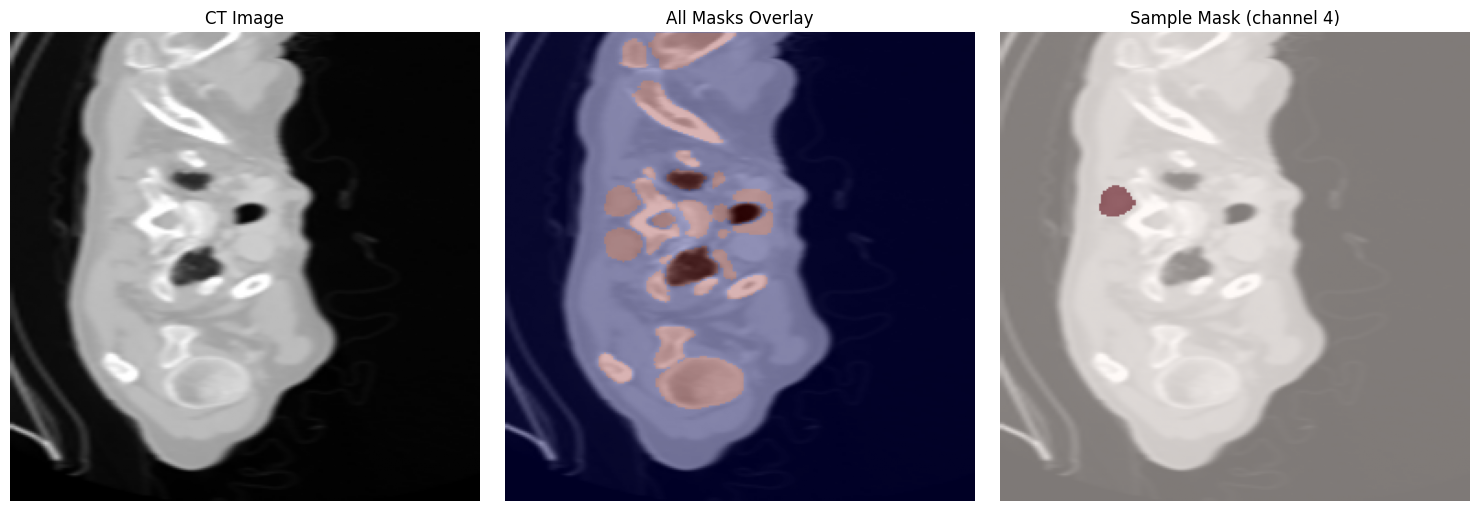


样本可视化已保存


In [8]:
import matplotlib.pyplot as plt

# 获取一个样本
sample_img, sample_mask = train_ds[len(train_ds)//2]

print(f"图像形状: {sample_img.shape}")
print(f"掩码形状: {sample_mask.shape}")

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 原始CT图像
axes[0].imshow(sample_img[0], cmap='gray')
axes[0].set_title('CT Image')
axes[0].axis('off')

# 所有掩码叠加
all_masks = sample_mask.sum(dim=0).numpy()
axes[1].imshow(sample_img[0], cmap='gray')
axes[1].imshow(all_masks, alpha=0.3, cmap='jet')
axes[1].set_title('All Masks Overlay')
axes[1].axis('off')

# 单个掩码示例（选择第一个非空掩码）
for i in range(sample_mask.shape[0]):
    if sample_mask[i].sum() > 0:
        axes[2].imshow(sample_img[0], cmap='gray')
        axes[2].imshow(sample_mask[i], alpha=0.5, cmap='Reds')
        axes[2].set_title(f'Sample Mask (channel {i})')
        axes[2].axis('off')
        break

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_visualization.png'), dpi=100, bbox_inches='tight')
plt.show()
print("\n样本可视化已保存")

## 8. 创建模型

In [9]:
# 创建模型
model = UNet2D(in_ch=1, out_ch=len(label_map), features=[32, 64, 128, 256]).to(device)

# 优化器和损失函数
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# 打印模型信息
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n模型参数统计:")
print(f"  总参数量: {total_params:,}")
print(f"  可训练参数: {trainable_params:,}")
print(f"\n模型已创建并移至 {device}")


模型参数统计:
  总参数量: 7,769,237
  可训练参数: 7,769,237

模型已创建并移至 cuda


## 9. 训练模型（带实时监控）

# 训练历史记录
history = {
    'train_loss': [],
    'val_dice': [],
}

print(f"\n开始训练 {EPOCHS} 个epoch...\n")

for epoch in range(1, EPOCHS + 1):
    print(f"{'='*60}")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{'='*60}")
    
    # ========== 训练阶段 ==========
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (imgs, masks) in enumerate(train_bar):
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        # 前向传播
        preds = model(imgs)
        loss = criterion(preds, masks)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # 实时记录训练指标到 wandb
        if USE_WANDB and (batch_idx + 1) % LOG_EVERY_N_BATCHES == 0:
            wandb.log({
                'batch_loss': loss.item(),
                'epoch': epoch,
                'batch': batch_idx + 1,
            })
    
    avg_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    
    # ========== 验证阶段 ==========
    model.eval()
    dices = []
    val_bar = tqdm(val_loader, desc='Validation')
    
    # 用于记录样本图像
    sample_images = []
    sample_masks = []
    sample_preds = []
    
    with torch.no_grad():
        for batch_idx, (imgs, masks) in enumerate(val_bar):
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            preds = torch.sigmoid(model(imgs))
            preds_bin = (preds > 0.5).float()
            dice = dice_score(preds_bin, masks)
            dices.append(dice)
            val_bar.set_postfix({'dice': f'{dice:.4f}'})
            
            # 保存第一个batch的样本用于可视化
            if batch_idx == 0 and USE_WANDB and epoch % LOG_IMAGES_EVERY_N_EPOCHS == 0:
                sample_images = imgs.cpu()
                sample_masks = masks.cpu()
                sample_preds = preds_bin.cpu()
    
    val_dice = float(np.mean(dices)) if dices else 0.0
    history['val_dice'].append(val_dice)
    
    # ========== 打印结果 ==========
    print(f"\nEpoch {epoch} 结果:")
    print(f"  训练损失: {avg_loss:.4f}")
    print(f"  验证Dice: {val_dice:.4f}")
    
    # ========== 记录到 wandb ==========
    if USE_WANDB:
        log_dict = {
            'epoch': epoch,
            'train_loss': avg_loss,
            'val_dice': val_dice,
            'learning_rate': optimizer.param_groups[0]['lr'],
        }
        
        # 记录样本图像（每N个epoch一次）
        if epoch % LOG_IMAGES_EVERY_N_EPOCHS == 0 and len(sample_images) > 0:
            # 选择第一个样本
            img_sample = sample_images[0, 0].numpy()  # (H, W)
            mask_sample = sample_masks[0].sum(0).numpy()  # 所有通道合并 (H, W)
            pred_sample = sample_preds[0].sum(0).numpy()  # 所有通道合并 (H, W)
            
            # 创建对比图像
            import matplotlib.pyplot as plt
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(img_sample, cmap='gray')
            axes[0].set_title('CT Image')
            axes[0].axis('off')
            
            axes[1].imshow(img_sample, cmap='gray')
            axes[1].imshow(mask_sample, alpha=0.5, cmap='Reds')
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
            
            axes[2].imshow(img_sample, cmap='gray')
            axes[2].imshow(pred_sample, alpha=0.5, cmap='Blues')
            axes[2].set_title('Prediction')
            axes[2].axis('off')
            
            plt.tight_layout()
            
            log_dict['predictions'] = wandb.Image(fig)
            plt.close(fig)
        
        wandb.log(log_dict)
    
    # ========== 保存检查点 ==========
    checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_epoch{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'val_dice': val_dice,
    }, checkpoint_path)
    print(f"  检查点已保存: {checkpoint_path}")
    
    # 记录最佳模型到 wandb
    if USE_WANDB and val_dice == max(history['val_dice']):
        wandb.run.summary["best_val_dice"] = val_dice
        wandb.run.summary["best_epoch"] = epoch
    
    print()

print(f"\n{'='*60}")
print("训练完成！")
if USE_WANDB:
    print(f"查看完整训练报告: {wandb.run.get_url()}")
print(f"{'='*60}")

## 9. 训练模型

In [10]:
# 训练历史记录
history = {
    'train_loss': [],
    'val_dice': [],
}

print(f"\n开始训练 {EPOCHS} 个epoch...\n")

for epoch in range(1, EPOCHS + 1):
    print(f"{'='*60}")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"{'='*60}")
    
    # ========== 训练阶段 ==========
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc='Training')
    
    for imgs, masks in train_bar:
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        # 前向传播
        preds = model(imgs)
        loss = criterion(preds, masks)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    
    # ========== 验证阶段 ==========
    model.eval()
    dices = []
    val_bar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for imgs, masks in val_bar:
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            preds = torch.sigmoid(model(imgs))
            preds_bin = (preds > 0.5).float()
            dice = dice_score(preds_bin, masks)
            dices.append(dice)
            val_bar.set_postfix({'dice': f'{dice:.4f}'})
    
    val_dice = float(np.mean(dices)) if dices else 0.0
    history['val_dice'].append(val_dice)
    
    # ========== 打印结果 ==========
    print(f"\nEpoch {epoch} 结果:")
    print(f"  训练损失: {avg_loss:.4f}")
    print(f"  验证Dice: {val_dice:.4f}")
    
    # ========== 保存检查点 ==========
    checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_epoch{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'val_dice': val_dice,
    }, checkpoint_path)
    print(f"  检查点已保存: {checkpoint_path}")
    print()

print(f"\n{'='*60}")
print("训练完成！")
print(f"{'='*60}")


开始训练 5 个epoch...

Epoch 1/5


Training:   0%|          | 0/134 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 10. 训练历史可视化

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 训练损失曲线
axes[0].plot(range(1, EPOCHS + 1), history['train_loss'], marker='o', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(alpha=0.3)

# 验证Dice曲线
axes[1].plot(range(1, EPOCHS + 1), history['val_dice'], marker='o', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Validation Dice Score')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

print("训练历史图已保存")

## 11. 保存训练历史

In [ ]:
# 保存训练历史为JSON
history_path = os.path.join(OUTPUT_DIR, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"训练历史已保存到: {history_path}")

# 打印最终结果摘要
print("\n训练摘要:")
print(f"  最终训练损失: {history['train_loss'][-1]:.4f}")
print(f"  最终验证Dice: {history['val_dice'][-1]:.4f}")
print(f"  最佳验证Dice: {max(history['val_dice']):.4f} (Epoch {history['val_dice'].index(max(history['val_dice'])) + 1})")

## 12. 测试推理

In [ ]:
# 关闭 wandb 运行
if USE_WANDB:
    wandb.finish()
    print("✓ Weights & Biases 会话已关闭")
    print(f"完整报告链接: {wandb.run.get_url()}")

## 关闭实时监控

In [ ]:
# 在验证集上测试一个样本
model.eval()
test_img, test_mask = val_ds[len(val_ds)//2]
test_img_batch = test_img.unsqueeze(0).to(device)

with torch.no_grad():
    test_pred = torch.sigmoid(model(test_img_batch))
    test_pred_bin = (test_pred > 0.5).float()

# 移到CPU用于可视化
test_img = test_img.cpu()
test_mask = test_mask.cpu()
test_pred_bin = test_pred_bin[0].cpu()

# 可视化预测结果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 原始图像
axes[0, 0].imshow(test_img[0], cmap='gray')
axes[0, 0].set_title('CT Image')
axes[0, 0].axis('off')

# 真实掩码（所有通道）
axes[0, 1].imshow(test_img[0], cmap='gray')
axes[0, 1].imshow(test_mask.sum(dim=0), alpha=0.5, cmap='jet')
axes[0, 1].set_title('Ground Truth (All)')
axes[0, 1].axis('off')

# 预测掩码（所有通道）
axes[0, 2].imshow(test_img[0], cmap='gray')
axes[0, 2].imshow(test_pred_bin.sum(dim=0), alpha=0.5, cmap='jet')
axes[0, 2].set_title('Prediction (All)')
axes[0, 2].axis('off')

# 找三个非空的掩码进行对比
non_empty_channels = [i for i in range(test_mask.shape[0]) if test_mask[i].sum() > 0][:3]

for idx, ch in enumerate(non_empty_channels):
    # 真实掩码
    axes[1, idx].imshow(test_img[0], cmap='gray')
    axes[1, idx].contour(test_mask[ch], colors='red', linewidths=2, alpha=0.7)
    axes[1, idx].contour(test_pred_bin[ch], colors='green', linewidths=2, alpha=0.7, linestyles='dashed')
    axes[1, idx].set_title(f'Channel {ch}\n(Red=GT, Green=Pred)')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'test_inference.png'), dpi=150, bbox_inches='tight')
plt.show()

print("测试推理结果已保存")

# 计算这个样本的Dice
sample_dice = dice_score(test_pred_bin.unsqueeze(0), test_mask.unsqueeze(0))
print(f"\n测试样本Dice系数: {sample_dice:.4f}")

## 总结

训练完成后，你可以：

1. **使用训练好的模型**：检查点保存在 `outputs/checkpoint_epochX.pth`
2. **查看训练历史**：`outputs/training_history.json` 和 `outputs/training_history.png`
3. **进行评估**：使用 `segmentation_detection_analysis.ipynb` 进行详细评估

### 改进建议
- 增加训练轮数（epochs）以获得更好的效果
- 调整学习率和batch size
- 添加数据增强（旋转、翻转、弹性变形等）
- 尝试不同的损失函数（Dice Loss、Focal Loss等）
- 使用学习率调度器